# Regresión Lineal Ordinaria

## a. Carga de datos

In [2]:
import pandas as pd
import numpy as np

url = 'http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
df = df.drop('Unnamed: 0', axis=1)
istrain_str = df['train']
istrain = np.asarray([True if s == 'T' else False for s in istrain_str])
df = df.drop('train', axis=1)

## b. Descripción de los datos

In [13]:
print df.shape
df.info()
df.describe()

(97, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 9 columns):
lcavol     97 non-null float64
lweight    97 non-null float64
age        97 non-null int64
lbph       97 non-null float64
svi        97 non-null int64
lcp        97 non-null float64
gleason    97 non-null int64
pgg45      97 non-null int64
lpsa       97 non-null float64
dtypes: float64(5), int64(4)
memory usage: 6.9 KB


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


## c. Normalización de los datos

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled['lpsa'] = df['lpsa']

## d. Generación del modelo de regresión lineal

In [4]:
import sklearn.linear_model as lm
X = df_scaled.ix[:,:-1]
N = X.shape[0]
X.insert(X.shape[1], 'intercept', np.ones(N))
y = df_scaled['lpsa']
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]
linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(Xtrain, ytrain)



LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

## e. Pesos y Z-score de cada predictor

In [5]:
ypred_train = linreg.predict(Xtrain)
from sklearn.metrics import mean_squared_error
sum_squares = np.power(ytrain - ypred_train, 2)
mse_train = mean_squared_error(ytrain, ypred_train)
n = ytrain.shape[0]
d = Xtrain.shape[1]
var_est = mse_train * n / (n - d - 1)
diag_values = np.diag(np.linalg.pinv(np.dot(Xtrain.T, Xtrain)))
z_scores = np.divide(linreg.coef_, np.sqrt(np.multiply(var_est, diag_values)))
print "\n", "{:<15}{:<20}{}".format("Attribute", "Weight", "Z_score")
for attribute, weight, z_score in zip(Xtrain.columns.values, linreg.coef_, z_scores):
    print "{:<15}{:<20}{}".format(attribute, weight, z_score)


Attribute      Weight              Z_score
lcavol         0.676016344389      5.3198281924
lweight        0.261693609264      2.72697258323
age            -0.140733744231     -1.38382296228
lbph           0.209060521232      2.03804576167
svi            0.303623322499      2.44787594268
lcp            -0.287001843752     -1.85074858539
gleason        -0.0211949345062    -0.145411215384
pgg45          0.265576136543      1.72279320502
intercept      2.46493292212       27.3592531411


## f. Error de predición utilizando cross-validation

In [6]:
yhat_test = linreg.predict(Xtest)
mse_test = np.mean(np.power(yhat_test - ytest, 2))
print "mse test: ", mse_test
from sklearn import cross_validation
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()
print "{:<5}{:<20}".format("k", "mse")
for k in range(5, 11):
    k_fold = cross_validation.KFold(len(Xm), k)
    mse_cv = 0
    for i, (train, val) in enumerate(k_fold):
        linreg = lm.LinearRegression(fit_intercept=False)
        linreg.fit(Xm[train], ym[train])
        yhat_val = linreg.predict(Xm[val])
        mse_fold = np.mean(np.power(yhat_val - ym[val], 2))
        mse_cv += mse_fold
    mse_cv = mse_cv / k
    print "{:<5}{:<20}".format(k, mse_cv)

mse test:  0.521274005508
k    mse                 
5    0.956514631616      
6    0.957083189771      
7    0.895319106006      
8    0.879992445353      
9    0.818545479043      
10   0.757237472963      


## g. QQ plot para los errores de predicción de cada dato de entrenamiento

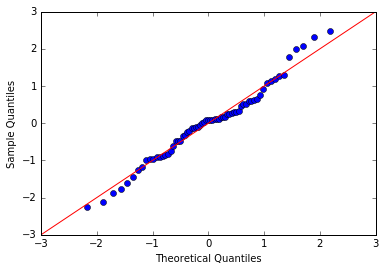

In [10]:
%matplotlib inline
import statsmodels.api as sm
fig = sm.qqplot(ypred_train - ytrain, fit=True, line='45')